# All protein GSP dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score



In [ ]:

# Load data
data = pd.read_csv('/content/drive/MyDrive/Reegina /Data/graph-based descriptor/all_pdb_gsp.csv')
data = data.drop(columns=['PROTEIN IDS'])
X = data.drop(columns=["ln(kf)"])
y = data['ln(kf)']
# Display basic statistics and check skewness
print(data.describe())
print(data.skew())

# Plot histograms to visualize distributions
data.hist(figsize=(12, 10))
plt.show()

In [8]:
# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop(columns=["ln(kf)"]))

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_scaled, data['ln(kf)'], test_size=0.3, random_state=42)

# Training models
rf_model = RandomForestRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=2).fit(X_train, y_train)
svr_model = SVR(kernel='rbf').fit(X_train, y_train)
elastic_net = ElasticNet(random_state=42).fit(X_train, y_train)

# Voting Regressor
voting_regressor = VotingRegressor(estimators=[('rf', rf_model), ('gb', gb_model), ('svr', svr_model)])
voting_regressor.fit(X_train, y_train)

# Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=[('rf', rf_model), ('gb', gb_model), ('svr', svr_model), ('elastic_net', elastic_net)],
    final_estimator=Ridge(random_state=42)
)
stacking_regressor.fit(X_train, y_train)

# Model evaluation
y_pred_rf = rf_model.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

y_pred_gb = gb_model.predict(X_test)
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)
r2_gb = r2_score(y_test, y_pred_gb)

y_pred_svr = svr_model.predict(X_test)
rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
r2_svr = r2_score(y_test, y_pred_svr)

y_pred_en =elastic_net.predict(X_test)
rmse_en = mean_squared_error(y_test, y_pred_en, squared=False)
r2_en = r2_score(y_test, y_pred_en)

y_pred_voting = voting_regressor.predict(X_test)
rmse_voting = mean_squared_error(y_test, y_pred_voting, squared=False)
r2_voting = r2_score(y_test, y_pred_voting)

y_pred_stacking = stacking_regressor.predict(X_test)
rmse_stacking = mean_squared_error(y_test, y_pred_stacking, squared=False)
r2_stacking = r2_score(y_test, y_pred_stacking)

print("Random Forest Regressor RMSE:", rmse_rf, "R2:", r2_rf)
print("Gradient Boosting Regressor RMSE:", rmse_gb, "R2:", r2_gb)
print("SVR RMSE:", rmse_svr, "R2:", r2_svr)
print("Elastic Net RMSE:", rmse_en, "R2:", r2_en)
print("Voting Regressor RMSE:", rmse_voting, "R2:", r2_voting)
print("Stacking Regressor RMSE:", rmse_stacking, "R2:", r2_stacking)



Random Forest Regressor RMSE: 3.680786246232528 R2: 0.049838165715399674
Gradient Boosting Regressor RMSE: 3.6103574637572002 R2: 0.08585140826254323
SVR RMSE: 3.6837354714512123 R2: 0.04831492383062108
Elastic Net RMSE: 3.7095438251127923 R2: 0.034933146433033024
Voting Regressor RMSE: 3.5506784018923403 R2: 0.11582330470515967
Stacking Regressor RMSE: 4.145708757256581 R2: -0.20535219983330455


In [9]:
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.005, 0.01],
    'max_depth': [6, 8, 10],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

# Initialize the XGBoost regressor with the desired objective
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize the GridSearchCV object with cross-validation and scoring
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best estimator found by GridSearchCV
best_xgb = grid_search.best_estimator_

# Perform cross-validated predictions
y_pred_xgb_cv = cross_val_predict(best_xgb, X_train, y_train, cv=5)

# Evaluate the cross-validated predictions
xgb_r2_cv = r2_score(y_train, y_pred_xgb_cv)
xgb_rmse_cv = mean_squared_error(y_train, y_pred_xgb_cv, squared=False)

# Print the cross-validated performance metrics
print("Optimized XGBoost R² (Cross-validated):", xgb_r2_cv)
print("Optimized XGBoost RMSE (Cross-validated):", xgb_rmse_cv)

# Fit the best model on the entire training set
best_xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb_test = best_xgb.predict(X_test)

# Evaluate the test set predictions
xgb_r2_test = r2_score(y_test, y_pred_xgb_test)
xgb_rmse_test = mean_squared_error(y_test, y_pred_xgb_test, squared=False)

# Print the test set performance metrics
print("Optimized XGBoost R² (Test set):", xgb_r2_test)
print("Optimized XGBoost RMSE (Test set):", xgb_rmse_test)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Optimized XGBoost R² (Cross-validated): 0.002607093631023294
Optimized XGBoost RMSE (Cross-validated): 4.09764166950314
Optimized XGBoost R² (Test set): 0.07247210806729476
Optimized XGBoost RMSE (Test set): 3.636681737645937


# 2s proteins with both single and multidomain GSP dataset

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
data_path = '/content/drive/MyDrive/Reegina /Data/graph-based descriptor/2s_gsp.csv'
data = pd.read_csv(data_path, encoding = 'latin1')
data = data.drop(columns = ['PDB'])


In [24]:
# Assume 'ln(kf)' is the target and other columns are features
X = data.drop('ln(kf)', axis=1)
y = data['ln(kf)']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Initialize and train Random Forest Regressor
rf_model = RandomForestRegressor(random_state=2)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize and train Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=0)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
gb_r2 = r2_score(y_test, y_pred_gb)
gb_rmse = mean_squared_error(y_test, y_pred_gb, squared=False)

print("Random Forest R²:", rf_r2)
print("Random Forest RMSE:", rf_rmse)
print("Gradient Boosting R²:", gb_r2)
print("Gradient Boosting RMSE:", gb_rmse)




Random Forest R²: 0.5333447984369705
Random Forest RMSE: 1.9959113732828928
Gradient Boosting R²: 0.38715631760959834
Gradient Boosting RMSE: 2.769039921741387


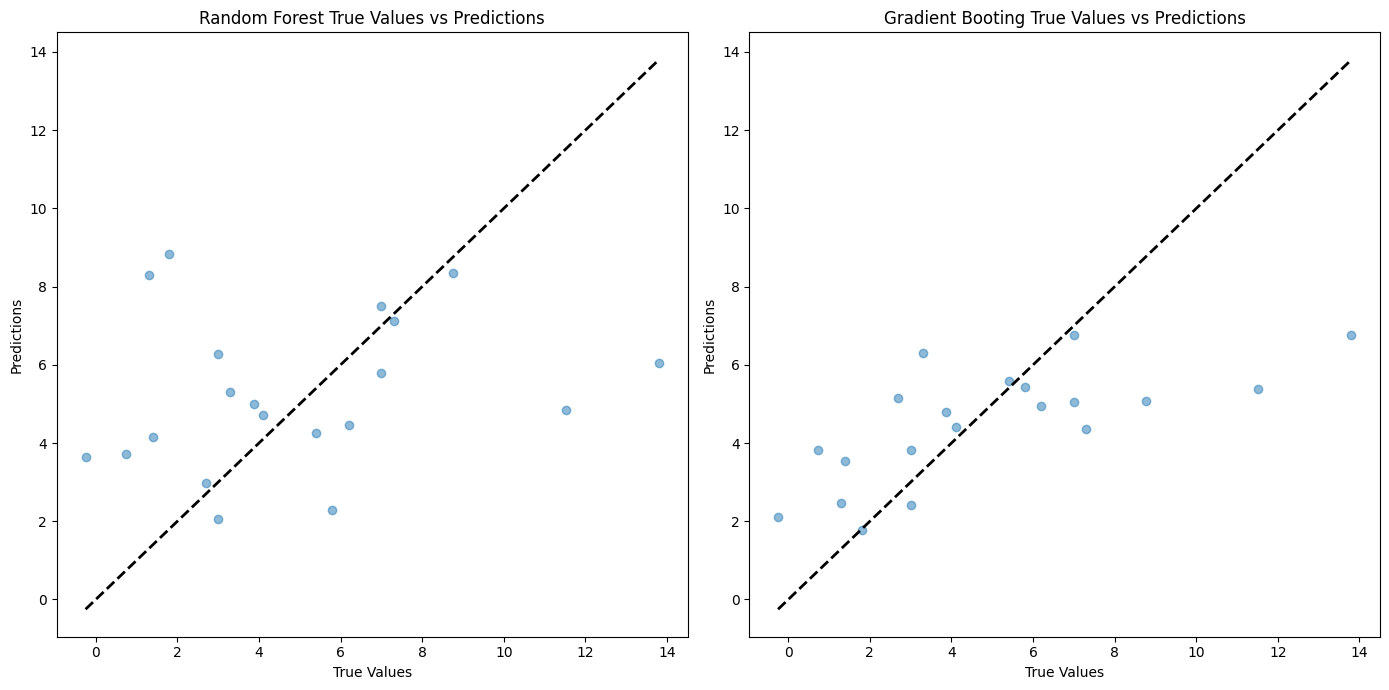

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.5)  # Ensure you use y_pred_simplified which is just calculated
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line showing perfect predictions
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Random Forest True Values vs Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_gb, alpha=0.5)  # Ensure you use y_pred_simplified which is just calculated
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line showing perfect predictions
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Gradient Booting True Values vs Predictions')

plt.tight_layout()
plt.show()

# 2s single domain proteins GSP dataset

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold

# Load and prepare the data
data_path = '/content/drive/MyDrive/Reegina /Data/graph-based descriptor/2s_singe_domain_gsp.csv'
data = pd.read_csv(data_path, encoding = 'latin1')
data = data.drop(columns = ['PDB ID'])
data

,Ln.K_f.,volume,amino_molecular_mass,unfolding_enthalpy_changes_of_chain,unfolding_Gibbs_free_energy_changes_of_chain,unfolding_hydration_heat_capacity_change,unfolding_hydration_entropy_change,unfolding_hydration_enthalpy_change,unfolding_Gibbs_free_energy_changes_of_chain.1,solvent_accessible_SA_unfolding,...,thermodynamic_transfer_hydrophobicity,surrounding_hydrophobicity,refractive_index,bulkiness,DEGREE,WEIGHTED_DEGREE,RESIDUE_FREQUENCY,CLUSTERING_COEFFICIENT,BETWEENNESS_CENTRALITY,PAGE_RANK
0,2.09,0.641396,0.730755,0.555999,0.592801,0.611029,0.635812,0.593622,0.592801,0.653995,...,0.681110,0.775156,0.644470,0.683864,0.727051,0.698510,0.886217,0.884034,0.632643,0.705955
1,1.48,0.621047,0.714295,0.514152,0.588578,0.524818,0.599125,0.570118,0.588578,0.622763,...,0.514808,0.760829,0.564022,0.597989,0.649547,0.626195,0.763289,0.827050,0.566904,0.614140
2,6.80,0.780541,0.813866,0.737452,0.807280,0.781250,0.773518,0.753219,0.807280,0.790063,...,0.773898,0.859065,0.771134,0.787563,0.817513,0.774253,0.908527,0.927581,0.790402,0.763534
3,11.75,0.755833,0.823053,0.769983,0.707520,0.706713,0.803218,0.724729,0.707520,0.816352,...,0.701663,0.893227,0.817213,0.802170,0.875566,0.829569,0.871017,0.966434,0.784657,0.832084
4,3.40,0.673642,0.744002,0.631753,0.681507,0.623417,0.667986,0.659144,0.681507,0.675080,...,0.617319,0.810842,0.658657,0.690296,0.794739,0.795486,0.862529,0.916475,0.722135,0.765351
5,6.91,0.685812,0.756708,0.568327,0.582459,0.569948,0.667763,0.612966,0.582459,0.641266,...,0.544281,0.788476,0.665409,0.706062,0.761505,0.710176,0.842427,0.896141,0.644237,0.720637
6,7.20,0.648870,0.740854,0.575290,0.611727,0.512321,0.603067,0.625418,0.611727,0.605487,...,0.543727,0.750194,0.611695,0.628316,0.711400,0.679603,0.770978,0.834196,0.630020,0.691488
7,3.87,0.676136,0.761224,0.696432,0.640271,0.611015,0.690263,0.624710,0.640271,0.666833,...,0.597819,0.770574,0.628300,0.656624,0.746623,0.749881,0.742966,0.867958,0.574209,0.713056
8,3.87,0.648699,0.744588,0.623530,0.645778,0.693649,0.719196,0.606264,0.645778,0.717454,...,0.705696,0.839607,0.633970,0.697087,0.784753,0.739924,0.731622,0.868036,0.662666,0.715018
9,6.98,0.628040,0.714768,0.529941,0.599350,0.540924,0.595028,0.562816,0.599350,0.619374,...,0.557434,0.775333,0.583883,0.622388,0.713403,0.646859,0.752635,0.848954,0.610080,0.655759


In [5]:
X = data.drop(columns = ['Ln.K_f.'])  # Adjust column names
y = data['Ln.K_f.']  # Adjust column names

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [11]:
ridge = Ridge()

# Define the parameter grid
param_grid = {
    'alpha': np.logspace(-4, 4, 20)  # Regularization strength
}

# Setup GridSearchCV
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search_ridge.fit(X_train, y_train)

# Best estimator
best_ridge = grid_search_ridge.best_estimator_

# Predictions
y_pred_ridge = best_ridge.predict(X_test)

# Evaluation
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Best Ridge Model: MSE =", mse_ridge, ", R^2 =", r2_ridge)
print("Best Parameters:", grid_search_ridge.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Ridge Model: MSE = 6.154963760020343 , R^2 = 0.5129520855616596
Best Parameters: {'alpha': 78.47599703514607}


In [21]:
# Adjust model parameters to reduce complexity
simplified_rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10,
                                      min_samples_leaf=4, max_features='sqrt', random_state=0)
simplified_rf.fit(X_train, y_train)
y_pred_simplified = simplified_rf.predict(X_test)

# Evaluate the simplified model
simplified_mse = mean_squared_error(y_test, y_pred_simplified)
simplified_r2 = r2_score(y_test, y_pred_simplified)
print(f"Simplified Model: MSE = {simplified_mse}, R^2 = {simplified_r2}")


Simplified Model: MSE = 5.908080187682771, R^2 = 0.5324882085518792


In [16]:
from sklearn.model_selection import cross_val_score

# Setup the model
simplified_rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=10,
                                      min_samples_leaf=4, max_features='sqrt', random_state=0)

# Perform cross-validation for MSE
mse_scores = cross_val_score(simplified_rf, X_scaled, y, cv=10, scoring='neg_mean_squared_error')

# Convert scores to positive values (because cross_val_score returns negative values for MSE)
mse_scores = -mse_scores

# Print results
print("MSE Scores:", mse_scores)
print("Average MSE:", mse_scores.mean())
print("Standard Deviation of MSE:", mse_scores.std())


MSE Scores: [ 4.74058062  6.80559272  4.73243827  2.31229163  1.58884439  6.28295189
  4.44445752  4.65863831  9.23958959 10.21814571]
Average MSE: 5.502353066483977
Standard Deviation of MSE: 2.5886195359891166


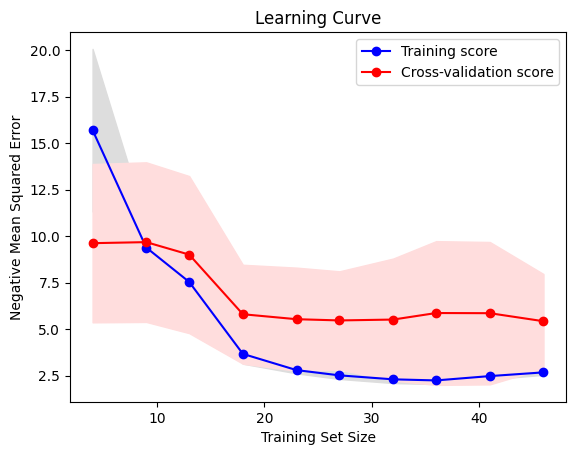

In [17]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Generate learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = simplified_rf,
    X = X_scaled,
    y = y,
    train_sizes = np.linspace(0.1, 1.0, 10),
    cv = 10,
    scoring = 'neg_mean_squared_error'
)

# Calculate mean and standard deviation for training set scores
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for validation set scores
validation_mean = -np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot the learning curves
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color="#FFDDDD")
plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, validation_mean, 'o-', color="r", label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Negative Mean Squared Error")
plt.legend(loc="best")
plt.show()


In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import  train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

# Assuming X_scaled and y are already defined
# Split the data into training and testing sets
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


# Initialize the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(random_state=2)

# Fit the GridSearchCV to find the best hyperparameters
gb_regressor.fit(X_train, y_train)

# Perform cross-validated predictions
y_pred_gb = gb_regressor.predict(X_test)

# Evaluate the test set predictions
gb_r2_test = r2_score(y_test, y_pred_gb)
gb_mse_test = mean_squared_error(y_test, y_pred_gb)

# Print the test set performance metrics
print(" Gradient Boosting R² (Test set):", gb_r2_test)
print("Gradient Boosting RMSE (Test set):", gb_mse_test)


 Gradient Boosting R² (Test set): 0.520351056056255
Gradient Boosting RMSE (Test set): 6.061460854237014


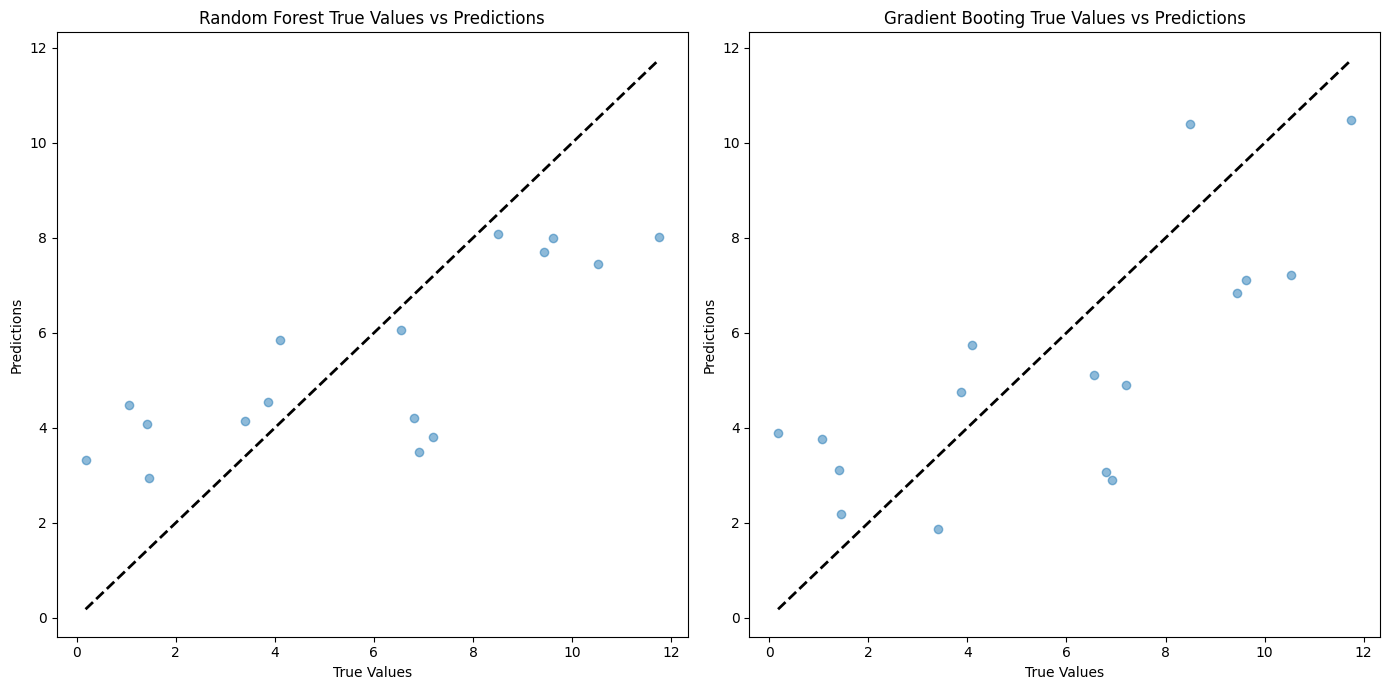

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_simplified, alpha=0.5)  # Ensure you use y_pred_simplified which is just calculated
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line showing perfect predictions
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Random Forest True Values vs Predictions')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_gb, alpha=0.5)  # Ensure you use y_pred_simplified which is just calculated
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Line showing perfect predictions
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Gradient Booting True Values vs Predictions')

plt.tight_layout()
plt.show()

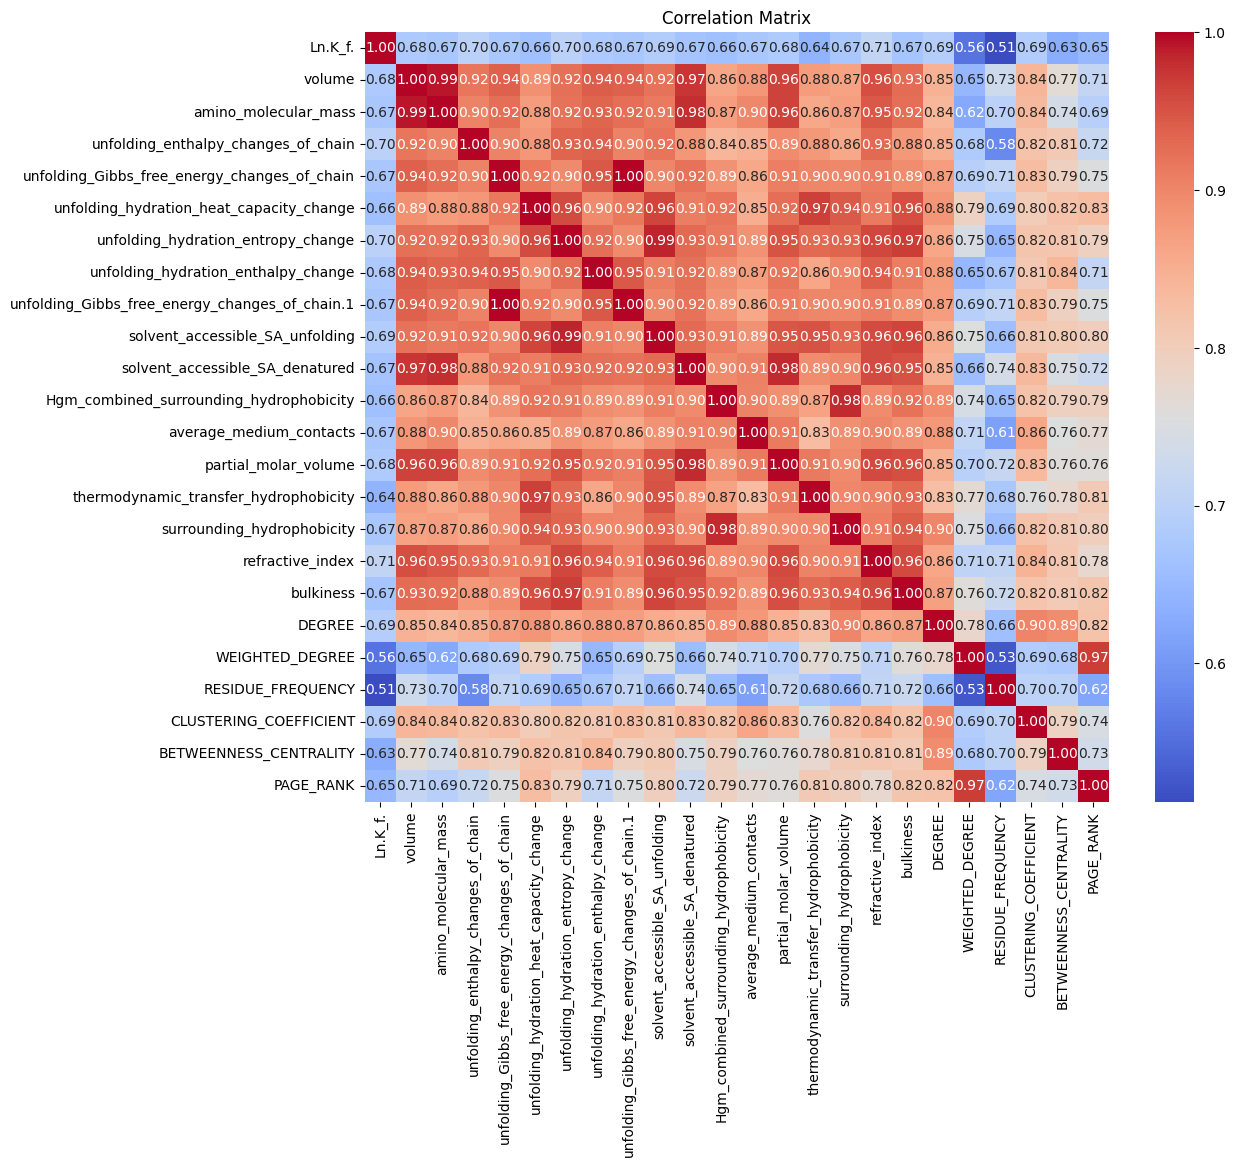

In [20]:
import seaborn as sns
# Assuming X_train is a DataFrame
if isinstance(data, pd.DataFrame):
    corr = data.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
else:
    print("X_train needs to be a Pandas DataFrame for correlation analysis.")
